
# 範例 : Transformer encoder
***
- 本範例目標是藉由手刻一個transformer encoder 並且實用在一個簡單的 encoder 應用上 以增進學員對課程的了解
-- 實做 Transformer encoder 以更了解　課程內容
-- 應用 Transformer encoder 解決一個ＮＥＲ的問題



# [教學目標]
- 了解 transformer encoder 其結構和如何實作 transformer encoder 
- 了解如何應用 transformer encoder 


# [範例重點]

- 觀察 TransformerEncoder 的建立
- 觀察 TransformerEncoderLayer 的建立
-- 使用 MultiHeadAttentionSubLayer
-- 使用 PosFeedForwardSubLayer
- 觀察如何使用 建立的 TransformerEncoder
-- 使用 TransformerEncoder 做序列生成 
-- 如何使用 SequenceTAG 模型 訓練一個 NER 模型

# [範例結構]
- TransformerEncoder 模型和 SequenceTAG 實作
- NER 資料準備
- 應用 SequenceTAG 訓練 NER 模型

In [1]:
# import 需要的 packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext import data
from torchtext import datasets


# 實做 TransformerEncoder
- TransformerEncoder 就是桃紅色的區塊
-- 首先是 Input & Potion Embedding
-- 然後是 把 embedding 輸入到一層層疊在一起的 TransformerEncoder Layer(層)

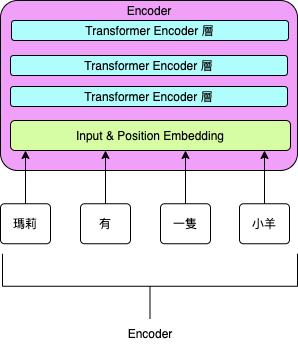

In [2]:
## 啟動參數
## hidden_dim 內部 embedding 大小
## feedforward_dim  feedforward 中間層大小
## n_enc_layers 幾層 Transformer Layers
## n_attn_heads 幾個 attention heads 
## dropout dropout 比例
## dec_voca_length  字彙集合大小
## max_pos_length  最大 decode 序列長度
## device 

## 輸入值
## src_sentence 編碼句子　
## src_mask　編碼遮罩　

class TransformerEncoder(nn.Module):
    """ Transformer 的 encoder """
    def __init__(self, hidden_dim, feedforward_dim, n_enc_layers, n_attn_heads, dropout, src_voca_length, max_pos_length , device):
        super().__init__()

        self.device = device
      
        # 字元 embedding 
        self.src_tok_embedding = nn.Embedding(src_voca_length , hidden_dim ) 

        # 位址 embedding 
        # 原作是用設定的 但是也有提到自學效果也一樣, 我們在這邊嘗試用deep learning 自學的
        self.src_pos_embedding = nn.Embedding(max_pos_length, hidden_dim)  

        # 建立 n_enc_layers 層的 Transformer Encoder 層
        self.transformer_encoder_layers = nn.ModuleList([TransformerEncoderLayer(hidden_dim, 
                                            feedforward_dim,
                                            n_enc_layers,
                                            n_attn_heads, 
                                            dropout, 
                                            device) for _ in range(n_enc_layers)])

        self.dropout = nn.Dropout(dropout)  

    def forward(self, src_sentence, src_mask):
        
        #src_sentence shape [batch size, src len]
        #src_mask shape [batch size, src len]
        
        batch_size = src_sentence.shape[0]
        src_len = src_sentence.shape[1]
        
        # 產生 position 數列 pos shape  [batch size, src len]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # 將 token embedding 和 position embedding 相加
        # 這邊的操作比較不直觀<-- 但是根據研究 這兩個 embedding 在空間上近似正交所以可以直接相加 （或是可以參照李鴻毅老師的 youtube 的解釋）

        src_sentence = self.dropout(self.src_tok_embedding(src_sentence)  + self.src_pos_embedding(pos))

        #src_sentence shape  [batch size, src len, hid dim]
        # 將 轉換embedding 好的 src sentence 輸入 n_enc_layers 層的 transformer encoder layers 
        
        for layer in self.transformer_encoder_layers:
            src_sentence , encoder_self_attention = layer(src_sentence, src_mask)
            
        # 輸出最後一層的 hidden layer and encoder self attention    
        # src_sentence shape  [batch size, src len, hid dim]
        # encoder_self_attention shape [batch , attention heads, src len, src len]

        return src_sentence , encoder_self_attention

# 實做 TransformerEncoderLayer
- 實作在transformerEncoder 使用多層 的TransformerEncoderLayer
- 參考論文原版圖

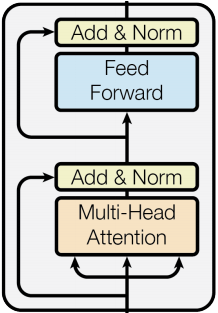


In [3]:
## 啟動參數
## hidden_dim 內部 embedding 大小
## feedforward_dim  feedforward 中間層大小
## n_enc_layers 幾層 Transformer Layers
## n_attn_heads 幾個 attention heads 
## dropout dropout 比例
## device 

## 輸入值
## src_sentence 編碼句子　
## src_mask　編碼遮罩　

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim , feedforward_dim, n_enc_layers, n_attn_heads, dropout , device):
        super().__init__()

        # 建立 Multi Head self Attention 子層
        self.self_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim,n_attn_heads,dropout,device)
        # self attention 子層 layer norm
        self.self_attn_layernorm = nn.LayerNorm(hidden_dim)

        # 建立 Position Wise Feedforward  子層
        self.feedforward_sublayer = PosFeedForwardSubLayer(hidden_dim,feedforward_dim,dropout)
        # Position Wise Feedforward 子層 layer norm
        self.feedforward_layernorm = nn.LayerNorm(hidden_dim)

        self.dropout = nn.Dropout(dropout)
  
    def forward(self, src_embedding, src_mask):
        #src_sentence shape [batch size, src len, hid dim]
        #src_mask shape [batch size, src len]

        #self attention 輸入值 代表 K Q V 和 mask
        _src,  encoder_self_attention = self.self_attention_sublayer(src_embedding, src_embedding, src_embedding, src_mask)

        #dropout, residual 殘差 connection and layer norm （Add & Norm）
        src_embedding = self.self_attn_layernorm(src_embedding + self.dropout(_src))

        #src_sentence shape  [batch size, src len, hid dim]

        #positionwise feedforward 子層
        _src = self.feedforward_sublayer(src_embedding)

        #dropout, residual 殘差 and layer norm （Add & Norm）
        src_embedding = self.feedforward_layernorm(src_embedding + self.dropout(_src))

        # 輸出 經過兩層處理的 src_sentence hidden layer 和 src_sentence self attention
        #src_sentence shape [batch size, src len, hid dim]
        #encoder_self_attention    [batch size, attension heads , src len,  src len]
        return src_embedding , encoder_self_attention


# 實做 MultiHeadAttentionSubLayer
- encoder and decoder 會同時共用的 MultiHeadAttention SubLayer 

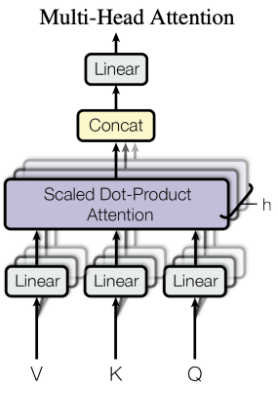

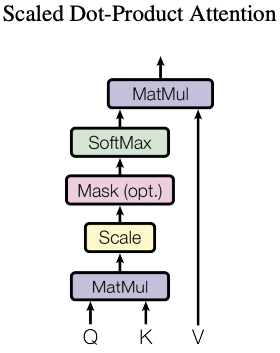

In [4]:
## 啟動參數
## hidden_dim 內部 embedding 大小
## n_attn_heads 幾個 attention heads 
## dropout dropout 比例
## device 

## 輸入值
## query_input, --> Q
## key_input, --> K
## value_input, --> V
## mask 遮罩

class MultiHeadAttentionSubLayer(nn.Module):
    def __init__(self, hidden_dim , n_attn_heads, dropout, device):
        super().__init__()

        # 確定 設定的 hidden layer 維度可以被 attention head 整除
        assert hidden_dim % n_attn_heads ==0

        # hidden layer 維度
        self.hidden_dim = hidden_dim

        # multi-heads 的個數
        self.n_attn_heads = n_attn_heads

        # 平均分到每個 multi-head 的 維度
        self.head_dim = hidden_dim // n_attn_heads

        # 就是在課程中提到的 Wq Wk Wv
        self.full_conn_q = nn.Linear(hidden_dim, hidden_dim)
        self.full_conn_k = nn.Linear(hidden_dim, hidden_dim)
        self.full_conn_v = nn.Linear(hidden_dim, hidden_dim)

        # 最後結果再過一層 線性轉換
        self.full_conn_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)

        # 根據維度大小調整 attention 值 以免維度太大 Q dot K 結果過大影響學習效率    
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query_input, key_input, value_input, mask = None):
        batch_size = query_input.shape[0]

        #query_input shape [batch size, query len, hid dim]
        #key_input shape [batch size, key len, hid dim]
        #value_input shape [batch size, value len, hid dim]

        Q = self.full_conn_q(query_input)
        K = self.full_conn_k(key_input)
        V = self.full_conn_v(value_input)

        #Q shape [batch size, query len, hid dim]
        #K shape [batch size, key len, hid dim]
        #V shape [batch size, value len, hid dim]

        # 將 attention 切成多塊小的 attention
        def split_attention(Q, K, V):
            Q = Q.view(batch_size, -1, self.n_attn_heads, self.head_dim)
            K = K.view(batch_size, -1, self.n_attn_heads, self.head_dim)
            V = V.view(batch_size, -1, self.n_attn_heads, self.head_dim)
            return Q , K , V

        # 將 attention 的 2 和 3 維度轉置 以達到將 attention head 提到前面 而分開每個 attention head
        def seperate_heads(Q, K, V):
            Q = Q.permute(0, 2, 1, 3) # (batch_size, self.n_heads , query len , self.head_dim)
            K = K.permute(0, 2, 1, 3) # (batch_size, self.n_heads , key len , self.head_dim)
            V = V.permute(0, 2, 1, 3) # (batch_size, self.n_heads , value len , self.head_dim)
            return Q , K , V

        Q, K, V = split_attention(Q, K, V)

        Q, K, V = seperate_heads (Q, K, V)

    
        # 調整過的 dot product attention, 由於之前分開了每個 attention head 
        # 所以現在只要把 Ｋ的最後兩個維度轉置 就可以 by attention head 求得 Q dot K
        scaled_dot_product_similarity = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #scaled_dot_product_similarity = [batch size, n heads, query len, key len]

        if mask is not None:
            scaled_dot_product_similarity = scaled_dot_product_similarity.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(scaled_dot_product_similarity, dim = -1)
        #attention shape [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x shape[batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x shape [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        #x shape [batch size, query len, hid dim]

        x = self.full_conn_o(x)

        #x shape [batch size, query len, hid dim]

        return x, attention

# 實做 PosFeedForwardSubLayer
- encoder and decoder 同時共用的 PosFeedForward SubLayer 

In [5]:
class PosFeedForwardSubLayer(nn.Module):
    def __init__(self, hidden_dim, ff_dim, dropout):
        super().__init__()
        self.full_conn_1 = nn.Linear(hidden_dim, ff_dim)
        self.full_conn_2 = nn.Linear(ff_dim,  hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x shape [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.full_conn_1(x)))

        #x shape [batch size, seq len, pf dim]

        x = self.full_conn_2(x)

        #x shape [batch size, seq len, hid dim]

        return x

# 實做 SequenceTAG
- 處理 序列TAGGING 序列分類工作
- 叫用 TransformerEnoderLayer
- 對輸入字串的每一個字進行 pos_lbl_length 個分類的預測


In [6]:
## 啟動參數
## encoder　Transformer encoder
## pos_lbl_length 預計輸出的每個字 分類數
## word_pad_idx encoder padding index  
## pos_pad_idx pos padding index  
## device 

## 輸入值
## word 要分類的字串

class SequenceTAG(nn.Module):
    def __init__(self,encoder, hidden_dim , pos_lbl_length , word_pad_idx , device):
        super().__init__()

        self.encoder = encoder
        self.word_pad_idx = word_pad_idx
        self.device = device
        self.full_conn_out = nn.Linear(hidden_dim, pos_lbl_length)


    def make_word_mask(self, word):

        #src = [batch size, src len]

        word_mask = (word != self.word_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return word_mask

    def forward(self, word):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]

        word_mask = self.make_word_mask(word)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        word_enc , encoder_self_attention = self.encoder(word, word_mask)

        output = self.full_conn_out(word_enc)

        return output,  encoder_self_attention
  

# NER 資料準備

NER，也稱為專有名稱識別，是自然語言處理中的一項基本任務。
具名實體通常是指在文本中具有特定含義的實體，通常包括人員名稱，地點名稱，組織名稱，日期和時間，專有名詞等。
NER系統從非結構化輸入文本中提取上述實體，並可以根據業務需求識別更多類型的實體。
例如產品名稱，型號，價格等。因此，實體的概念可以非常廣泛。

## 我們這次選擇的資料集是 torchtext 所提供的 ＵＤＰＯＳ 資料集
### Universal Dependencies Version 2 POS Tagged data
### 將英文文本的每個字分成以下數類


* ADP：介词 on, of, at, with, by, into, under
* ADV：副词 really, already, still, early, now
* AUX：助動詞 can, will  
* CCONJ：连接词 and, or, but, if, while, although
* DET：限定词，冠词 the, a, some, most, every, no, which
* INTJ：感嘆詞
* NOUN：名詞
* NUM：數字
* PART：
* PRON：代词 he, their, her, its, my, I, us
* PROPN：專有名詞
* PUNCT：標點符號
* SCONJ：從屬連詞
* SYM：符號
* VERB：動詞
* X：其他

## 範例：
### SRC: ['What', 'if',    'Google', 'Morphed', 'Into', 'GoogleOS', '?'] 
### TRG: ['PRON', 'SCONJ', 'PROPN',  'VERB',    'ADP',  'PROPN',    'PUNCT']



In [7]:
WORD = data.Field(init_token="<bos>", eos_token="<eos>")
UD_TAG = data.Field(init_token="<bos>", eos_token="<eos>")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset, dev_dataset, test_dataset = datasets.UDPOS.splits(
    fields=(('word', WORD), ('udtag', UD_TAG))) #(None, None)

WORD.build_vocab(train_dataset.word, min_freq = 1)
UD_TAG.build_vocab(train_dataset.udtag, min_freq = 1)

print ("句子字元數: " , len(WORD.vocab) , ", 目標數: " ,len(UD_TAG.vocab) , UD_TAG.vocab.freqs)
print ("Sample WORD:", test_dataset[0].word , "TRG:", test_dataset[0].udtag)
print (max ([ len(data.word) for data in train_dataset]) , max ([ len(data.word) for data in dev_dataset]) , max ([ len(data.word) for data in test_dataset]))

句子字元數:  19676 , 目標數:  21 Counter({'NOUN': 34781, 'PUNCT': 23679, 'VERB': 23081, 'PRON': 18577, 'ADP': 17638, 'DET': 16285, 'PROPN': 12946, 'ADJ': 12477, 'AUX': 12343, 'ADV': 10548, 'CCONJ': 6707, 'PART': 5567, 'NUM': 3999, 'SCONJ': 3843, 'X': 847, 'INTJ': 688, 'SYM': 599})
Sample WORD: ['What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?'] TRG: ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']
159 75 81


In [8]:
BATCH_SIZE = 64
from torchtext.data import Field, BucketIterator, TabularDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, dev_dataset, test_dataset), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.word),
     device = device)

# 實際建立模型
- 設定重要參數
    - 建立一個 hidden embedding 256，三層encoder layer，八個attention heads
    - position wise feedforward 中間層 512 dropout 0.1 learning rate: 0.00005
    - 最長句長 160
- 如果要保留訓練出來的模型，建議和 vocabulary 一起儲存

In [9]:
INPUT_DIM = len(WORD.vocab)
MAX_SENT_LENGTH = 160
HID_DIM = 256
ENC_LAYERS = 3
ENC_HEADS = 8
ENC_FF_DIM = 512
ENC_DROPOUT = 0.1
WORD_PAD_IDX = WORD.vocab.stoi[WORD.pad_token]
POS_PAD_IDX = UD_TAG.vocab.stoi[UD_TAG.pad_token]
LEARNING_RATE = 0.00005

print ("目前 device: ", device)


enc = TransformerEncoder(HID_DIM, ENC_FF_DIM, ENC_LAYERS, ENC_HEADS, ENC_DROPOUT,INPUT_DIM,  MAX_SENT_LENGTH, device)

model = SequenceTAG(enc, HID_DIM , len(UD_TAG.vocab) , WORD_PAD_IDX , device).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = POS_PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

目前 device:  cpu


# 初始化參數和統計參數

In [10]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model.apply(initialize_weights);

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 6,664,725 trainable parameters


# model training and evaluate function
- 注意 我們要輸入的字串是 batch.word
- 每個字的預測 batch.udtag


In [11]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        word = batch.word
        pos_lbl = batch.udtag
        
        optimizer.zero_grad()
        
        output, _  = model(word)
                     
        # word shape [batch size, 句長]
        # pos_lbl shape [batch size, 句長]
        # output shape [batch size, 句長, 預測分類數]

        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = pos_lbl.contiguous().view(-1)

        #output shape[batch size * 句長 - 1, 預測分類數]
        #trg shape [batch size * 句長 - 1]
                       
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [12]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        total_corr = 0
        total_pos_pred = 0
        for i, batch in enumerate(iterator):

            word = batch.word
            pos_lbl = batch.udtag

            output, _  = model(word)
            
            # word shape [batch size, 句長]
            # pos_lbl shape [batch size, 句長]
            # output shape [batch size, 句長, 預測分類數]
            
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = pos_lbl.contiguous().view(-1)
            
            #output shape[batch size * 句長 - 1, 預測分類數]
            #trg shape [batch size * 句長 - 1]
            
            pred_token = output.argmax(1)

            _correct = (pred_token == trg).sum()
            total_corr += _correct.item()
            total_pos_pred += pred_token.shape[0]
            
             
            #print (_correct.sum())

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator) , total_corr / total_pos_pred

# 實際訓練
- Ｔ4 大約 4.3 秒一個 epoch
- 訓練十個 epoch 就有一定的成績了
- 我最好的 Valiation Loss: 0.379

In [13]:
import time
N_EPOCHS = 20
CLIP = 1


best_valid_loss = 9999999

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss , val_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    #torch.save(model.state_dict(), model_dir + 'model-{}.pt'.format(epoch))
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),  'best-model.pt')
    
    print ("Epoch {} training time: {:.2f} sec Training Loss: {:.3f} , Valiation Loss: {:.3f} , Val Acc: {:.3f}".format( epoch , end_time - start_time , train_loss , valid_loss , val_acc ))
 

Epoch 0 training time: 64.75 sec Training Loss: 2.108 , Valiation Loss: 1.379 , Val Acc: 0.550
Epoch 1 training time: 63.53 sec Training Loss: 1.193 , Valiation Loss: 0.744 , Val Acc: 0.711
Epoch 2 training time: 65.27 sec Training Loss: 0.746 , Valiation Loss: 0.529 , Val Acc: 0.779
Epoch 3 training time: 65.30 sec Training Loss: 0.549 , Valiation Loss: 0.451 , Val Acc: 0.801
Epoch 4 training time: 73.09 sec Training Loss: 0.443 , Valiation Loss: 0.421 , Val Acc: 0.810
Epoch 5 training time: 63.91 sec Training Loss: 0.373 , Valiation Loss: 0.405 , Val Acc: 0.816
Epoch 6 training time: 66.39 sec Training Loss: 0.331 , Valiation Loss: 0.409 , Val Acc: 0.811
Epoch 7 training time: 61.56 sec Training Loss: 0.296 , Valiation Loss: 0.409 , Val Acc: 0.814
Epoch 8 training time: 61.86 sec Training Loss: 0.271 , Valiation Loss: 0.414 , Val Acc: 0.815
Epoch 9 training time: 63.19 sec Training Loss: 0.250 , Valiation Loss: 0.421 , Val Acc: 0.815
Epoch 10 training time: 62.85 sec Training Loss: 0

# 看看在 test set 的表現
## 我的 test set loss 0.395 正確率達到 81.4% 差強人意

In [14]:
import math

model.load_state_dict(torch.load('best-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}  | Test Accuary: {test_acc:.3f}')

| Test Loss: 0.388  | Test Accuary: 0.811


# 任選定一個 test set 中的一個句子看看結果


In [15]:

def predict_sequence(sentence, src_field, predict_field ,  model, device):
    
    model.eval()
        
    tokens = [token.lower() for token in sentence]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output , encoder_self_attention = model(src_tensor)
        
    output_dim = output.shape[-1]
            
    output = output.contiguous().view(-1, output_dim)
    pred_token = output.argmax(1)

    predict_tokens = [predict_field.vocab.itos[i] for i in pred_token]

    return predict_tokens, encoder_self_attention 


example_idx = 1002
word = vars(test_dataset.examples[example_idx])['word']
pos = vars(test_dataset.examples[example_idx])['udtag']
result = ["{}({})".format(wrd,pos_tag) for wrd, pos_tag in zip(word,pos)]
# print (" ".join(result))



pos_predict,  encoder_self_attention  = predict_sequence(word, WORD, UD_TAG, model, device)

print ("原句" , chr(9).join(word))
print ("標註" , chr(9).join(pos))
print ("預測" , chr(9).join(pos_predict))


原句 "	If	a	school	bus	carrying	fifty	children	drove	off	a	cliff	,	killing	everyone	involved	...	that	would	be	a	tragedy	"	.
標註 PUNCT	SCONJ	DET	NOUN	NOUN	VERB	NUM	NOUN	VERB	ADP	DET	NOUN	PUNCT	VERB	PRON	ADJ	PUNCT	PRON	AUX	AUX	DET	NOUN	PUNCT	PUNCT
預測 PUNCT	SCONJ	DET	NOUN	NOUN	VERB	NUM	NOUN	VERB	ADP	DET	PROPN	PUNCT	VERB	PRON	ADJ	PUNCT	PRON	AUX	AUX	DET	NOUN	PUNCT	PUNCT
